# Indian Sign Language Detection

## Data Preprocessing

### Importing

In [1]:
import torch, torchvision
import numpy as np
from torch import nn
from pathlib import Path
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer

c:\Users\18raj\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data from Folder

In [2]:
train_path = Path("Indian/")
train_path_list = list(train_path.glob("*/*.jpg"))

test_path = Path("data/test/")
test_path_list = list(test_path.glob("*/*.jpg"))

val_path = Path("data/val/")
val_path_list = list(val_path.glob("*/*.jpg"))

print(f"dataset Sizes: \nTraining Data: {len(train_path_list)}\nValidation Data: {len(val_path_list)}\nTest Data: {len(test_path_list)}")

dataset Sizes: 
Training Data: 28742
Validation Data: 7000
Test Data: 7000


### Declaring the transforms that will be applied to the dataset

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Loading data from Folders and applying Transforms

In [4]:
train_data = datasets.ImageFolder(root=train_path, transform=train_transforms, target_transform=None)
val_data = datasets.ImageFolder(root=val_path, transform=test_transforms, target_transform=None)
test_data = datasets.ImageFolder(root=test_path, transform=test_transforms, target_transform=None)

### Creating Data Loaders to allow easy Iteration over the data

In [5]:
train_dataloader = DataLoader(dataset=train_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)

## CNN MODEL

### Model Architectures

In [6]:
class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, dropout_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )
        self.dropout = nn.Dropout(dropout_size)
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.dropout(x)
        x = self.conv_block_2(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [7]:
model1 = Model(input_shape=3, hidden_units=10, output_shape=len(train_data.classes), dropout_size=0.25)
print(model1.parameters())

<generator object Module.parameters at 0x000001DB70E172C8>


## Helper Functions

### Function to run the training Loop

In [8]:
def train(model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.train()
    train_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return train_loss, accuracy

### Function to run testing loop

In [9]:
def test(model: nn.Module,
        loss_fn: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    test_loss = test_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return test_loss, accuracy

## Running Model

### HyperParameters

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.001)

### Training and Validating

In [11]:
results = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

start_time = timer()
epochs = 5
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model=model1,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test(model=model1,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn)
    
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f}")

 20%|██        | 1/5 [03:24<13:36, 204.22s/it]

Epoch: 0 | Train Loss: 3.5558 | Train Acc: 0.0275 | Test Loss: 3.5543 | Test Acc: 0.0280


 40%|████      | 2/5 [07:01<10:35, 211.86s/it]

Epoch: 1 | Train Loss: 3.5510 | Train Acc: 0.0343 | Test Loss: 3.5499 | Test Acc: 0.0287


 60%|██████    | 3/5 [10:26<06:57, 208.86s/it]

Epoch: 2 | Train Loss: 3.5368 | Train Acc: 0.0414 | Test Loss: 3.5205 | Test Acc: 0.0448


 80%|████████  | 4/5 [13:46<03:25, 205.18s/it]

Epoch: 3 | Train Loss: 2.6512 | Train Acc: 0.3076 | Test Loss: 0.2969 | Test Acc: 0.9398


100%|██████████| 5/5 [17:05<00:00, 205.07s/it]

Epoch: 4 | Train Loss: 0.2363 | Train Acc: 0.9486 | Test Loss: 0.0613 | Test Acc: 0.9864
Total Training Time: 1025.361


## Analysing the model

### Plot of Loss and Accuracy with respect to epochs

In [17]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_accuracy"]
    test_acc = results["test_accuracy"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

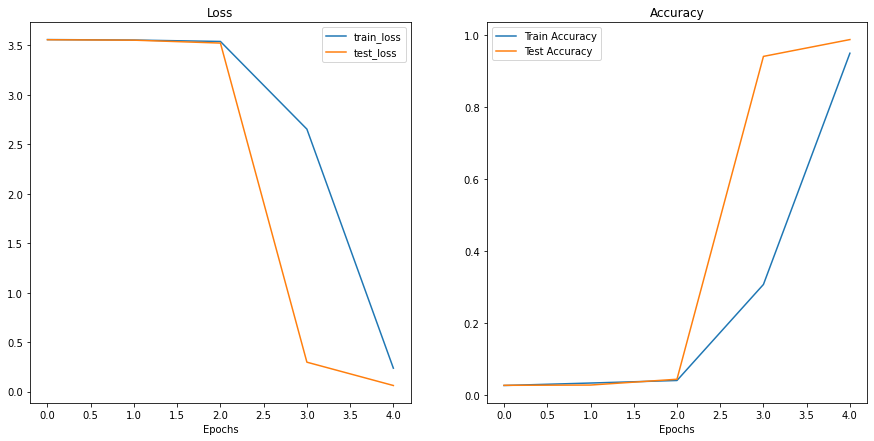

In [18]:
plot_loss_curves(results)

### Saving the model

In [14]:
MODEL_PATH = Path(".")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model-sgd"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model to {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to model-sgd


### Testing the Model on Test Dataset

In [15]:
test_loss, test_acc = test(model=model1,
                        dataloader=test_dataloader,
                        loss_fn=loss_fn)
print("Final Results.....")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Final Results.....
Test Loss: 0.0607 | Test Accuracy: 0.9863
